## Inicialización

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
print(df.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [4]:
print(df.sample(n=10))

       file_name  real_age
1213  001213.jpg        21
5134  005134.jpg        23
7158  007175.jpg        65
3480  003480.jpg        33
6561  006565.jpg        25
7197  007215.jpg        94
5007  005007.jpg        39
6763  006770.jpg        65
4524  004524.jpg        38
2375  002375.jpg        30


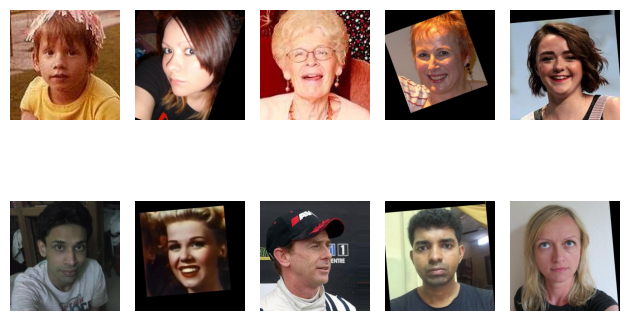

In [5]:
direction = '/datasets/faces/final_files/'

plt.figure()
for i in range(10):
    file_path = direction + df.iloc[i]['file_name']
    image = Image.open(file_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))
    plt.axis('off')
plt.tight_layout()
plt.show()

### Conclusiones

**Conclusiones sobre edades**    
-No hay datos que sea necesario eliminar, ya que las edades van del año a los 100. El rango es correcto en cuanto a edad de personas.    
-Las imágenes varían en cuanto a si son frontales o en perfil en diferentes grados, así como hay edades variadas.    
-Algunas imágenes tiene cierta variedad en su rotación.     
-Todas las imágenes son de rostros. 

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    data_train = ImageDataGenerator(rescale=1/255,
                                      validation_split=0.2)
    
    train_gen_flow = data_train.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [8]:
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        shuffle=False)

    return test_gen_flow

In [9]:
def create_model(input_shape):
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [11]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
    init_code = '''
if __name__ == "__main__":
    data_path = '/content/drive/MyDrive/datasets/'
    train_data = load_train(data_path)
    test_data = load_test(data_path)
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, test_data, epochs=10)
'''
    f.write(init_code)

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3503s 9s/step - loss: 286.4213 - mae: 12.6869 - val_loss: 288.0661 - val_mae: 12.9180    
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - loss: 124.2758 - mae: 8.5498 - val_loss: 194.8630 - val_mae: 10.4635    
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 192ms/step - loss: 94.1243 - mae: 7.4898 - val_loss: 129.6693 - val_mae: 8.9566    
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - loss: 66.8392 - mae: 6.2052 - val_loss: 144.1805 - val_mae: 8.9139     
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 74s 193ms/step - loss: 51.3024 - mae: 5.5287 - val_loss: 115.4080 - val_mae: 8.4661    
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - loss: 44.3937 - mae: 5.0963 - val_loss: 116.3632 - val_mae: 8.5420    
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 192ms/step - loss: 30.6665 - mae: 4.2884 - val_loss: 88.2757 - val_mae: 7.1071    
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - loss: 27.2921 - mae: 4.0422 - val_loss: 88.8130 - val_mae: 7.2414     
Epoch 9/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - loss: 23.8010 - mae: 3.7632 - val_loss: 102.9268 - val_mae: 7.8462     
Epoch 10/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 192ms/step - loss: 21.2747 - mae: 3.5420 - val_loss: 95.1943 - val_mae: 7.6900      

## Conclusiones

-El modelo muestra un buen aprendizaje especialmente de las épocas 1 a la 7, ya que el error se reduce sustancialmente.    
-El error se reduce en todas las épocas en cuanto al conjunto de entrenaminto, pero en el conjunto d evalidación, a partir de la época 7 tiene un vaivén que podría significar sobreajuste. Sin embargo, se alcanza el objetivo señalado de tener un MAE menor a 8, por lo que el modelo es exitoso.   
-Se recomendaría usar un hiperparámetro como early stopping para dejar el modelo en la época ideal, que sería la 7.    
-Este modelo garantizaría un error medio de 7.1 años en la predicción de las fotos, lo cual, resulta beneficioso para los objetivos de la empresa, sin embargo, con los recursos suficinetes, podría mejorarse.    

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo